this was super hacky, basicallythere was some mismatch between the onset times and the quite obvious responses

So i extracted the real onset times from a different recording where i attatched the LED to the objective holder and then triggered it with the stimulus DAQ 

sorry i dont want to clean this up properly

In [2]:
%matplotlib widget
import numpy as np
from daio.h5 import lazyh5
import h5py, os, glob
import matplotlib.pyplot as plt


In [10]:
stim_path = os.path.expanduser("~/hpc-rw/stimulus_assembly.h5")

In [11]:
assembly = lazyh5(stim_path, readonly=0)
assembly

<IPython.core.display.JSON object>

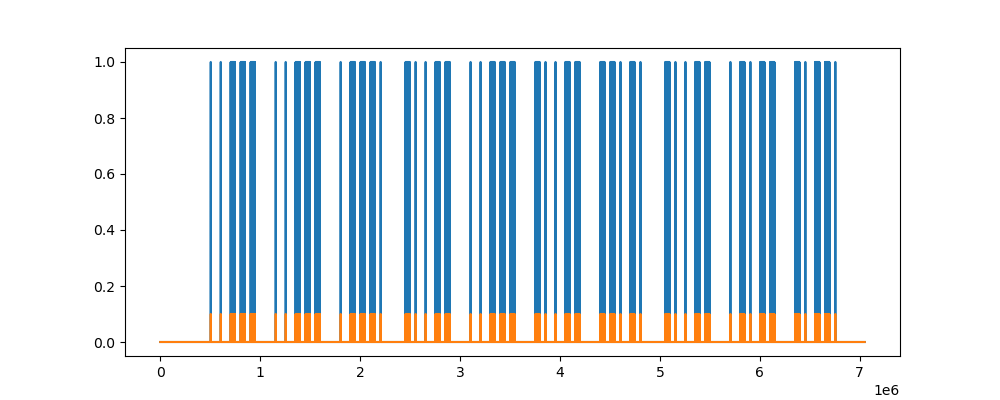

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,4))

ax.plot((np.abs(assembly["stimulus"].T)>=1e-7))
ax.plot(assembly["stimulus"].T)


In [8]:
optical_stim = (np.abs(assembly["stimulus"].T)>=1e-7)*0.1

In [9]:
assembly["stimulus"] = optical_stim

PermissionError: [Errno 13] Unable to synchronously open file (unable to open file: name = '/home/lubo12/hpc-r/lfm2025/recordings/20250828_1708_LB_zf552_para_f1_2/stimset_LB_zf2/stimulus_assembly.h5', errno = 13, error message = 'Permission denied', flags = 1, o_flags = 2)

In [14]:
from i_o import VolumeReader
from tqdm.auto import tqdm
import cupy as cp
reader = VolumeReader("/home/lubo12/hpc-r/lfm2025/recordings/20250905_1818_stimulus_test/data.h5")
means = []
for frame_n, frame in tqdm(reader, desc="Generating raw video"):
    means.append(cp.asarray(frame).flatten().mean().get())
means = np.array(means)

/home/lubo12/.conda/envs/lfm1/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


Generating raw video:   0%|          | 0/11265 [00:00<?, ?it/s]

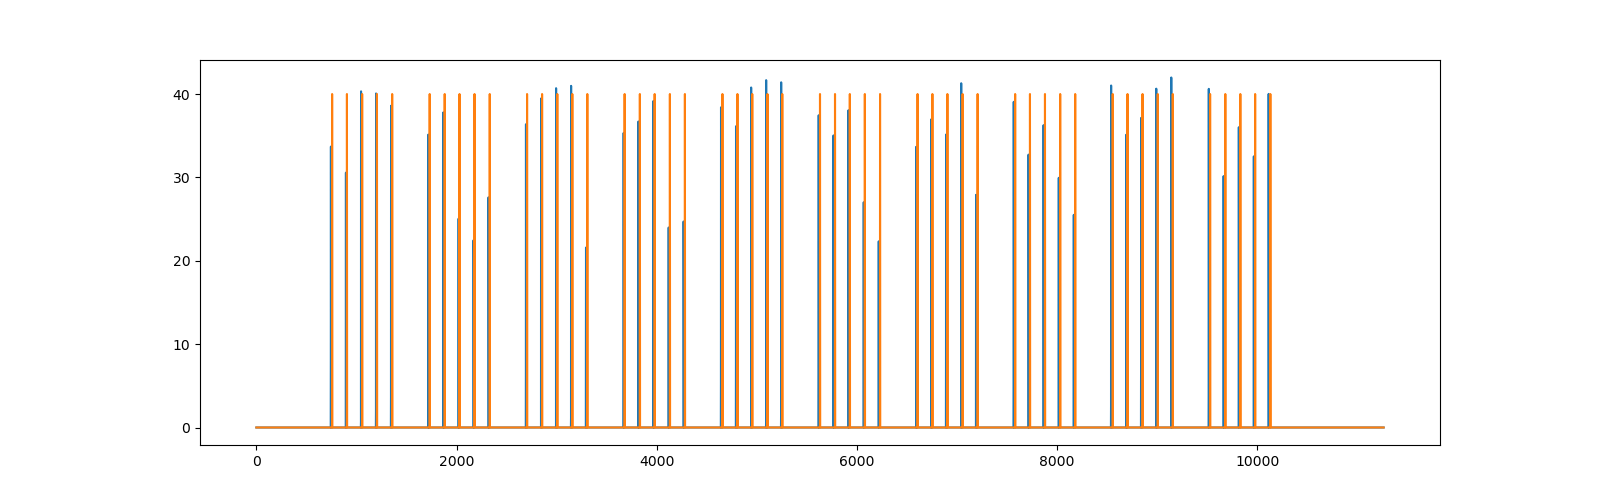

In [18]:
fig, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(means)
ax.plot(onsets_array*40)

In [15]:
bool_arr = optical_stim != 0
onsets = np.where(bool_arr & ~np.roll(bool_arr, 1) & ~np.roll(bool_arr, 2))[0]
onsets =75*(onsets / 50000)
onsets = onsets.astype(np.uint16)
onsets_array = np.zeros_like(means)
onsets_array[onsets] = 1


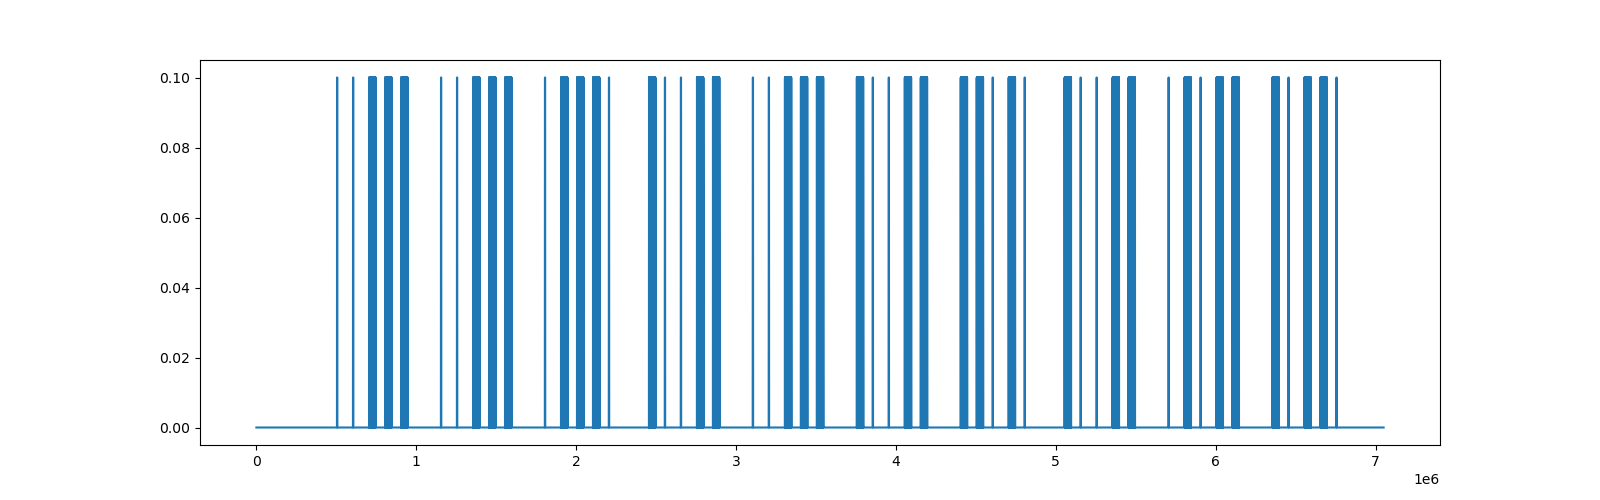

In [49]:
fig, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(optical_stim)

In [24]:
arr = np.where(np.diff(means).astype(int)>0)[0]
filtered = arr[np.diff(np.concatenate(([-np.inf], arr))) > 3]
filtered.shape

(50,)

In [25]:
onset_timestamps = lazyh5("/home/lubo12/hpc-r/lfm2025/recordings/20250905_1818_stimulus_test/data.h5")["tstmp"][filtered]


In [26]:
onset_timestamps -= onset_timestamps.min()

In [27]:
onset_timestamps

array([  0.        ,   2.00075936,   4.02843022,   6.01551461,
         8.01664281,  13.00590444,  15.00642323,  17.02167439,
        19.02227712,  21.02330184,  25.99992967,  28.0264492 ,
        30.02810311,  32.01546717,  34.00337625,  39.01980472,
        41.00697637,  43.00811625,  45.02185082,  47.02295971,
        51.9993763 ,  53.99959421,  56.02776933,  58.02898741,
        60.01680851,  65.01977396,  67.0068202 ,  69.00745273,
        71.02193403,  73.02309585,  78.02548051,  80.02586269,
        82.0006938 ,  84.02847123,  86.00351954,  91.01892781,
        93.00671411,  95.00708175,  97.02141047,  99.02375221,
       103.99867225, 106.02675581, 108.00082612, 110.02804589,
       112.029634  , 117.0181818 , 119.00586367, 121.02027941,
       123.02119207, 125.00963998])

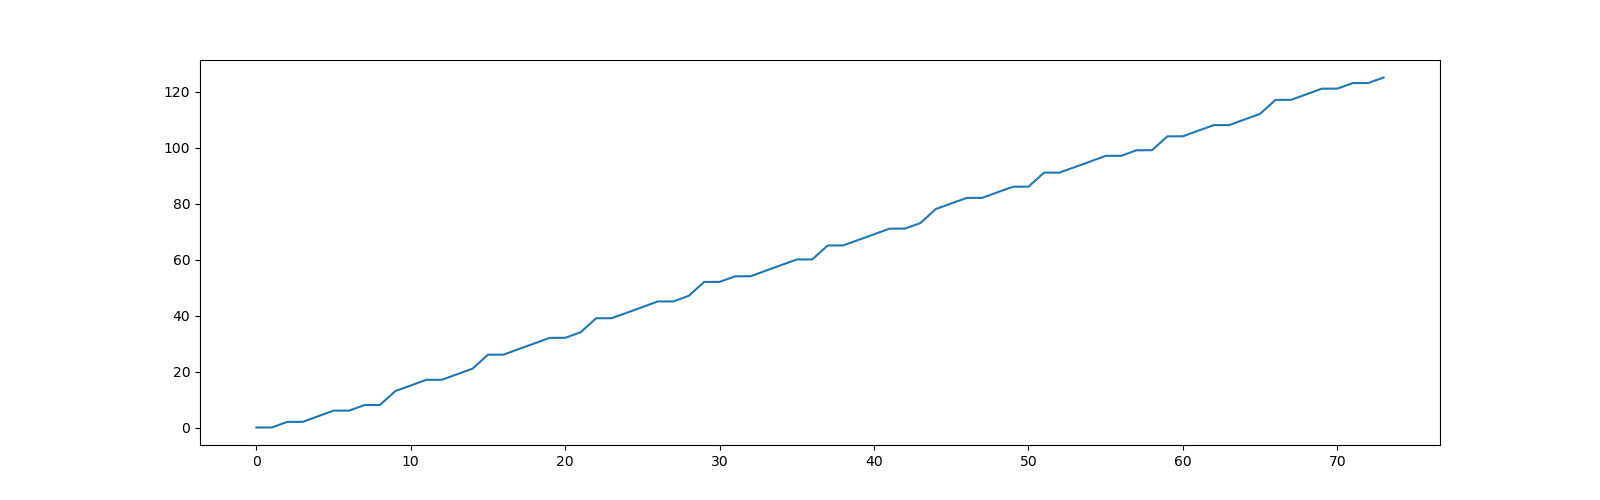

In [129]:
fig, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(onset_timestamps)

In [21]:
stimulus_sequence_order = np.array(stimulus_sequence_order)
stim_id_order = stimulus_sequence_order[stimulus_sequence_order!=0]

In [22]:
stim_lengths = []
for i in stim_id_order:
    onset = stim_data["stimulus_collection"][str(i)]["metadata"]["onset"]
    offset = stim_data["stimulus_collection"][str(i)]["metadata"]["offset"]
    duration = int((offset-onset)*75)
    if duration == 0.0:
        duration = 3
    stim_lengths.append(duration)
np.array(stim_lengths)

array([60,  3, 60,  3, 60, 60, 60,  3,  3, 60,  3,  3, 60, 60, 60,  3, 60,
        3, 60, 60, 60, 60,  3, 60,  3, 60, 60,  3,  3, 60, 60,  3,  3, 60,
       60, 60,  3,  3, 60, 60, 60,  3,  3, 60, 60,  3, 60, 60,  3, 60])

In [31]:
filtered.shape

(50,)

In [29]:
timestamps.shape

(11265,)

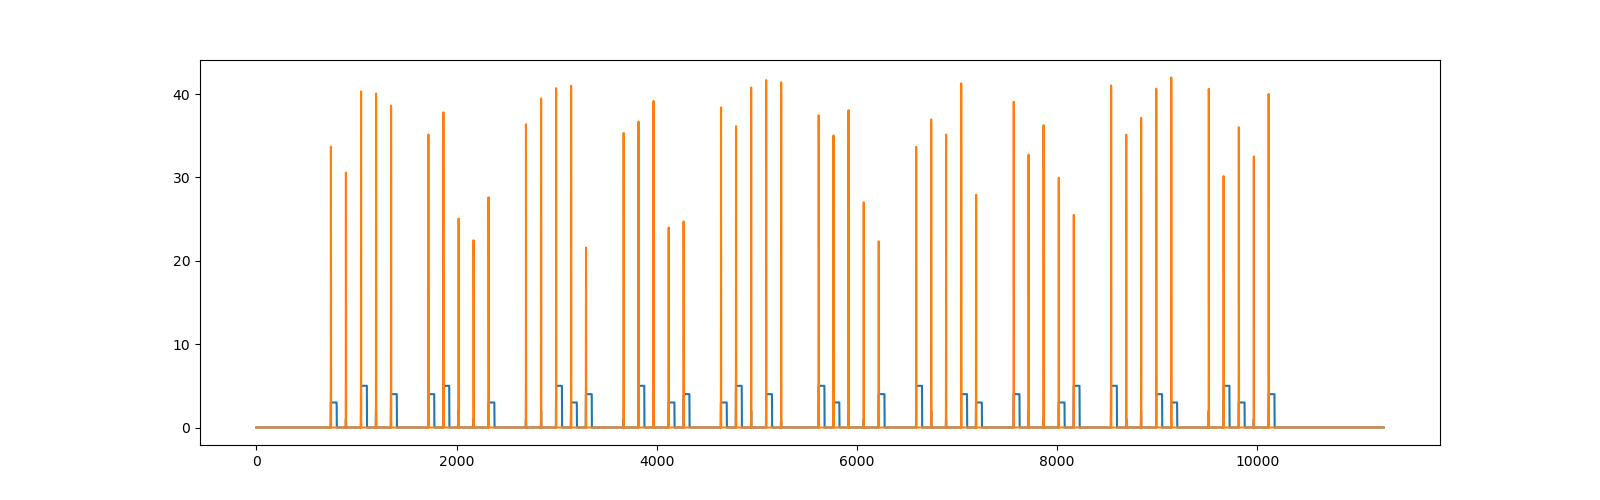

In [32]:
final_stimulus_id = np.zeros(timestamps.shape)
for i in range(len(filtered)):
    final_stimulus_id[filtered[i]:filtered[i]+stim_lengths[i]] = stim_id_order[i]
fig, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(final_stimulus_id)
ax.plot(means)

In [33]:
import pickle

# Write
with open("readable_75fps_stim_2.pkl", "wb") as f: pickle.dump((final_stimulus_id, stim_names), f)
# Read
# with open("readable_75fps_stim.pkl", "rb") as f: final_stimulus_id, stim_names = pickle.load(f)


In [19]:
from i_o import downsample_max
import json
stim_path = "~/hpc-r/lfm2025/recordings/20250828_1708_LB_zf552_para_f1_2/stimset_LB_zf2"
stim_data = lazyh5(os.path.expanduser(os.path.join(stim_path, "stimdata_conditioned.h5")))
samplerate = 50000 #stim_data["spec"]["samplerate"]
reverb_time = int(stim_data["spec"]["reverb_period"] * samplerate)

stimdict = {}
stim_names = {}
for i in range(len(stim_data["stimulus_collection"])):
    stimdict[i] = stim_data["stimulus_collection"][str(i)]["stimulus"]
    stim_names[i] = stim_data["spec"]["stimuli"][str(i)]["label"]

with open(os.path.expanduser(os.path.join(stim_path, "stimulus_assembly_info.json")), 'r') as f:
    stim_json = json.load(f)

stimulus_sequence_order = stim_json.get('stimulus_sequence_order', [])
assembly_info = stim_json.get('assembly_info', [])
total_duration = stim_json.get("assembly_duration", [])
final_stimulus = np.zeros(int(total_duration * samplerate))
final_stimulus_id = np.zeros(int(total_duration * samplerate))

for i, event_info in enumerate(assembly_info):
    stim_id = stimulus_sequence_order[i]
    if stim_id != 0:
        stim = stimdict[stim_id]
        onset_time = round(event_info.get('stimulus_period_onset') * samplerate)
        # if stim.shape[0]> 2*reverb_time:
        #     offset_time = round(event_info.get('offset') * samplerate)
        #     final_stimulus[onset_time:offset_time] = stim[reverb_time:-reverb_time]
        #     final_stimulus_id[onset_time:offset_time] = stim_id
        # else:
        offset_time = onset_time+stim[reverb_time:].shape[0]
        final_stimulus[onset_time:offset_time] = stim[reverb_time:]
        final_stimulus_id[onset_time:offset_time] = stim_id
timestamps = lazyh5("/home/lubo12/hpc-r/lfm2025/recordings/20250905_1818_stimulus_test/data.h5")["tstmp"]
timestamps -= np.nanmin(timestamps)
stim_time = np.arange(final_stimulus_id.shape[0])/samplerate 
stimulus_id_fps = np.zeros_like(timestamps)
for i in range(len(timestamps)):
    t0 = timestamps[i-1] if i>0 else 0
    t1 = timestamps[i]

    idx0 = np.searchsorted(stim_time, t0, side='left')
    idx1 = np.searchsorted(stim_time, t1, side='right')
    stim_ids_in_window = final_stimulus_id[idx0:idx1]
    if np.any(stim_ids_in_window != 0):
        stimulus_id_fps[i] = np.max(stim_ids_in_window)
# final_stimulus_id = downsample_max(final_stimulus_id, samplerate, 75)


In [ ]:
fig, ax = plt.subplots(1,1,figsize = (16,5))
ax.plot(np.diff(final_stimulus_id)>0)
ax.plot(onset_times)

In [142]:
stim_onsets = (np.where(np.diff(final_stimulus_id)>0)[0]+reverb_time+1)/50000 *75


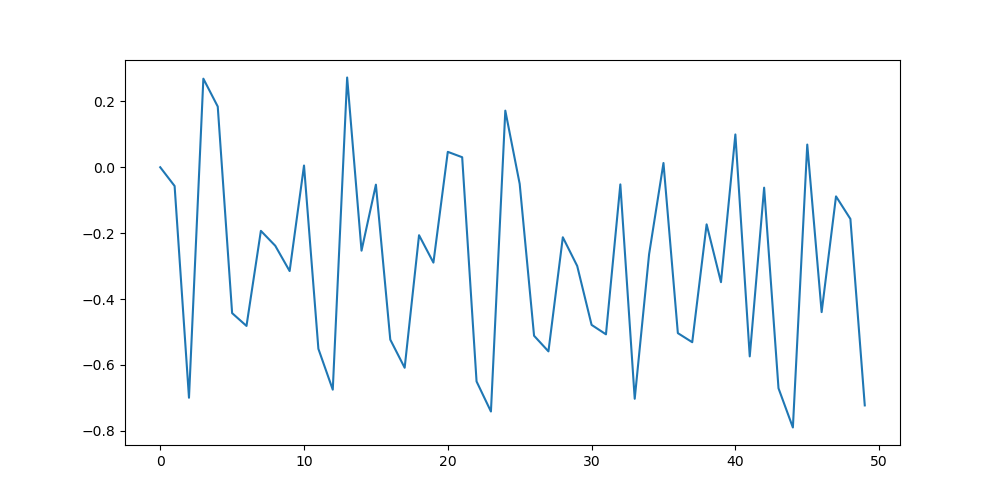

In [68]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot((onsets-onset_timestamps)*75)

In [65]:
onsets -= onsets.min()